# Electrical Panel Pattern Recognition - Exploratory POC

This notebook explores using Weaviate vector database with CLIP embeddings to identify patterns in electrical panel images.

**Goals:**
- Load electrical panel images into Weaviate
- Use vector similarity search to find compatible panels
- Identify incompatible panels based on visual patterns
- Build foundation for capacity analysis

## Setup

**Prerequisites:**
1. Start Weaviate: `docker compose up`
2. Install dependencies below

In [1]:
%pip install weaviate-client

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle, json, os, IPython, base64
import weaviate
import weaviate.classes as wvc
from weaviate.classes.config import Configure, Property, DataType
from PIL import Image
import io

## Connect to Weaviate

Connect to the locally running Weaviate instance (meter-image-weaviate container)

In [3]:
client = weaviate.connect_to_local()

print(f"Client created? {client.is_ready()}")
if client.is_ready():
    print("✓ Successfully connected to Weaviate")
else:
    print("✗ Connection failed - make sure Weaviate is running (docker compose up)")

Client created? True
✓ Successfully connected to Weaviate


## Create Electrical Panel Collections

Create two separate collections for EV charging compatibility classification:
- **CompatiblePanels**: Panels compatible with EV charging setup (Good folder)
- **IncompatiblePanels**: Panels not compatible with EV charging setup (Bad folder)

In [4]:
# Clean up any existing collections
for collection_name in ["CompatiblePanels", "IncompatiblePanels"]:
    if client.collections.exists(collection_name):
        client.collections.delete(collection_name)
        print(f"Deleted existing {collection_name} collection")

In [5]:
# Create collection for EV-compatible panels
client.collections.create(
    name="CompatiblePanels",
    vectorizer_config=Configure.Vectorizer.multi2vec_clip(
        image_fields=["image"]
    ),
    properties=[
        Property(name="image", data_type=DataType.BLOB),
        Property(name="filename", data_type=DataType.TEXT),
        Property(name="panel_type", data_type=DataType.TEXT),
        Property(name="notes", data_type=DataType.TEXT)
    ]
)

# Create collection for non-EV-compatible panels
client.collections.create(
    name="IncompatiblePanels",
    vectorizer_config=Configure.Vectorizer.multi2vec_clip(
        image_fields=["image"]
    ),
    properties=[
        Property(name="image", data_type=DataType.BLOB),
        Property(name="filename", data_type=DataType.TEXT),
        Property(name="panel_type", data_type=DataType.TEXT),
        Property(name="notes", data_type=DataType.TEXT)
    ]
)

print("✓ CompatiblePanels collection created")
print("✓ IncompatiblePanels collection created")

/home/elmunoz42/anaconda3/lib/python3.13/site-packages/weaviate/warnings.py:196: DeprecationWarning: Dep024: You are using the `vectorizer_config` argument in `collection.config.create()`, which is deprecated.
            Use the `vector_config` argument instead.
            
  warnings.warn(


✓ CompatiblePanels collection created
✓ IncompatiblePanels collection created


## Load Panel Images

Load electrical panel images from Good/ and Bad/ directories into their respective collections

In [7]:
# Supported image formats (including webp)
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp']

def load_images_to_collection(image_dir, collection_name, compatibility_status):
    """Load images from a directory into a Weaviate collection"""
    # Check if directory exists
    if not os.path.exists(image_dir):
        print(f"\n⚠️  Directory '{image_dir}' does not exist!")
        print(f"Please create the directory and add images to it.")
        return 0, 0
    
    collection = client.collections.get(collection_name)
    
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) 
                   if os.path.splitext(f)[1].lower() in image_extensions]
    
    print(f"\n{'='*60}")
    print(f"Loading {compatibility_status} panels from {image_dir}")
    print(f"Found {len(image_files)} images")
    print(f"{'='*60}")
    
    if len(image_files) == 0:
        print(f"⚠️  No images found in {image_dir}")
        return 0, 0
    
    success_count = 0
    error_count = 0
    
    for img in image_files:
        try:
            with open(f"{image_dir}{img}", "rb") as file:
                image_data = base64.b64encode(file.read()).decode('utf-8')
            
            collection.data.insert(
                properties={
                    "image": image_data,
                    "filename": img,
                    "panel_type": "unknown",
                    "notes": f"EV charging {compatibility_status}"
                }
            )
            success_count += 1
            if success_count % 5 == 0:
                print(f"  Loaded {success_count} images...")
        except Exception as e:
            print(f"✗ Error adding {img}: {e}")
            error_count += 1
    
    print(f"\n✓ Successfully loaded: {success_count} images")
    if error_count > 0:
        print(f"✗ Failed to load: {error_count} images")
    
    return success_count, error_count

# Load compatible panels (Good folder inside Images/)
good_count, good_errors = load_images_to_collection(
    "Images/Good/", 
    "CompatiblePanels", 
    "COMPATIBLE"
)

# Load incompatible panels (Bad folder inside Images/)
bad_count, bad_errors = load_images_to_collection(
    "Images/Bad/", 
    "IncompatiblePanels", 
    "INCOMPATIBLE"
)

print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
print(f"Compatible panels loaded: {good_count}")
print(f"Incompatible panels loaded: {bad_count}")
print(f"Total panels: {good_count + bad_count}")
print(f"{'='*60}")

if good_count == 0 and bad_count == 0:
    print(f"\n⚠️  SETUP REQUIRED:")
    print(f"1. Create 'Good/' and 'Bad/' folders inside 'Images/' directory")
    print(f"2. Place EV-compatible panel images in 'Images/Good/'")
    print(f"3. Place EV-incompatible panel images in 'Images/Bad/'")
    print(f"4. Re-run this cell to load the images")


Loading COMPATIBLE panels from Images/Good/
Found 1 images

✓ Successfully loaded: 1 images

Loading INCOMPATIBLE panels from Images/Bad/
Found 2 images

✓ Successfully loaded: 2 images

SUMMARY
Compatible panels loaded: 1
Incompatible panels loaded: 2
Total panels: 3


## Query Compatible Panels

Search for EV-compatible panels based on textual descriptions

In [8]:
def search_panels_by_text(query_text, collection_name="CompatiblePanels", limit=5):
    """Search for electrical panels using text description"""
    collection = client.collections.get(collection_name)
    
    res = collection.query.near_text(
        query=query_text,
        limit=limit
    )
    
    results = []
    for obj in res.objects:
        results.append({
            "filename": obj.properties.get("filename"),
            "panel_type": obj.properties.get("panel_type"),
            "notes": obj.properties.get("notes")
        })
    
    return results

# Example: Search compatible panels
print("Search compatible panels: 'electrical meter panel'")
results = search_panels_by_text("electrical meter panel", "CompatiblePanels", limit=3)
print(json.dumps(results, indent=2))

Search compatible panels: 'electrical meter panel'
[
  {
    "filename": "good-perfect-main-panel-300x400.webp",
    "panel_type": "unknown",
    "notes": "EV charging COMPATIBLE"
  }
]


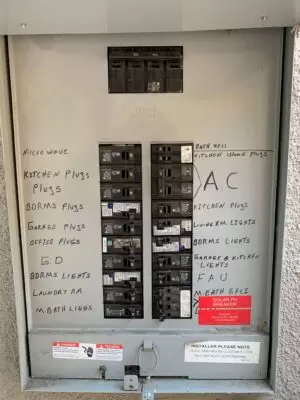

Top match: good-perfect-main-panel-300x400.webp


In [9]:
# Visualize top result from compatible panels
if results and results[0]['filename']:
    display(Image.open(f"Images/Good/{results[0]['filename']}"))
    print(f"Top match: {results[0]['filename']}")

## Image Similarity Search

Find similar panels within compatible or incompatible collections

In [10]:
def find_similar_panels(query_image_path, collection_name="CompatiblePanels", limit=5):
    """Find panels visually similar to the query image within a specific collection"""
    collection = client.collections.get(collection_name)
    
    # Read and encode query image
    with open(query_image_path, "rb") as file:
        query_image = base64.b64encode(file.read()).decode('utf-8')
    
    # Search for similar images
    res = collection.query.near_image(
        near_image=query_image,
        limit=limit
    )
    
    results = []
    for obj in res.objects:
        results.append({
            "filename": obj.properties.get("filename"),
            "panel_type": obj.properties.get("panel_type"),
            "notes": obj.properties.get("notes")
        })
    
    return results

Finding compatible panels similar to: good-perfect-main-panel-300x400.webp

Reference image:


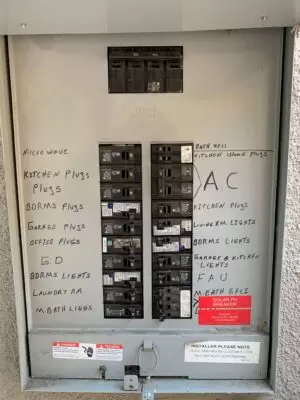


Top similar compatible panels:
[
  {
    "filename": "good-perfect-main-panel-300x400.webp",
    "panel_type": "unknown",
    "notes": "EV charging COMPATIBLE"
  }
]


In [11]:
# Example: Find similar compatible panels
# Get a reference image from Good folder
good_images = [f for f in os.listdir("Images/Good/") if os.path.splitext(f)[1].lower() in image_extensions]
if good_images:
    reference_image = f"Images/Good/{good_images[0]}"
    
    print(f"Finding compatible panels similar to: {os.path.basename(reference_image)}")
    print("\nReference image:")
    display(Image.open(reference_image))
    
    similar = find_similar_panels(reference_image, "CompatiblePanels", limit=4)
    print("\nTop similar compatible panels:")
    print(json.dumps(similar, indent=2))
else:
    print("No images found in Images/Good/ folder")

In [12]:
# Visualize similar compatible panels
if 'similar' in locals() and similar:
    print("Similar compatible panels (excluding self):")
    for i, result in enumerate(similar[1:4], 1):
        if result['filename']:
            print(f"\n{i}. {result['filename']}")
            display(Image.open(f"Images/Good/{result['filename']}"))

Similar compatible panels (excluding self):


## EV Compatibility Classification

Classify a new panel image by comparing it to both compatible and incompatible collections

In [13]:
def classify_panel_for_ev(query_image_path, limit=5):
    """
    Classify a panel for EV charging compatibility by comparing similarity
    to both compatible and incompatible panel collections
    """
    print("🔍 EV CHARGING COMPATIBILITY ANALYSIS")
    print("="*60)
    
    # Search in compatible panels
    compatible_matches = find_similar_panels(query_image_path, "CompatiblePanels", limit=limit)
    
    # Search in incompatible panels  
    incompatible_matches = find_similar_panels(query_image_path, "IncompatiblePanels", limit=limit)
    
    print("\n✅ COMPATIBLE PANEL MATCHES (Top 3):")
    print("-"*60)
    for i, panel in enumerate(compatible_matches[:3], 1):
        print(f"{i}. {panel['filename']}")
    
    print("\n❌ INCOMPATIBLE PANEL MATCHES (Top 3):")
    print("-"*60)
    for i, panel in enumerate(incompatible_matches[:3], 1):
        print(f"{i}. {panel['filename']}")
    
    # Simple classification based on which collection has closer matches
    # In production, you'd use actual distance scores
    print("\n" + "="*60)
    print("PRELIMINARY CLASSIFICATION:")
    print("Compare visual similarity above to make determination")
    print("="*60)
    
    return {
        "compatible_matches": compatible_matches,
        "incompatible_matches": incompatible_matches
    }

TEST PANEL: adding-an-ev-charger-to-garage-sub-panel-v0-wg5lbxzbsnmf1.webp


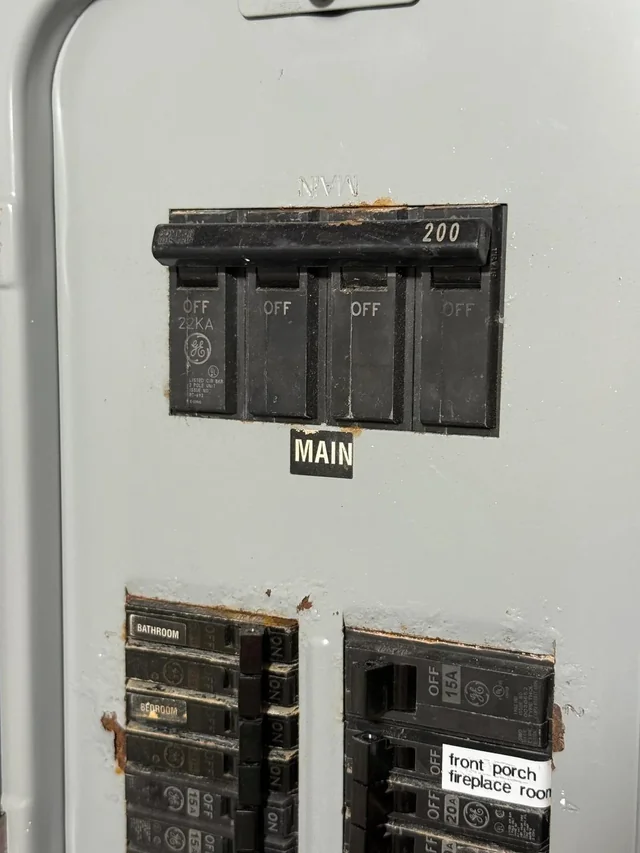

🔍 EV CHARGING COMPATIBILITY ANALYSIS

✅ COMPATIBLE PANEL MATCHES (Top 3):
------------------------------------------------------------
1. good-perfect-main-panel-300x400.webp

❌ INCOMPATIBLE PANEL MATCHES (Top 3):
------------------------------------------------------------
1. bad-2-300x400.webp
2. breaker-bad.webp

PRELIMINARY CLASSIFICATION:
Compare visual similarity above to make determination


In [14]:
# Test classification with a panel from TBD folder
tbd_images = [f for f in os.listdir("Images/TBD/") if os.path.splitext(f)[1].lower() in image_extensions] if os.path.exists("Images/TBD/") else []

if tbd_images:
    test_panel = f"Images/TBD/{tbd_images[0]}"
    
    print(f"TEST PANEL: {os.path.basename(test_panel)}")
    print("="*60)
    display(Image.open(test_panel))
    
    classification = classify_panel_for_ev(test_panel, limit=5)
else:
    print("No images in Images/TBD/ folder to test. Use an image from Good or Bad folder.")
    # Alternative: test with a Good image
    if 'good_images' in locals() and good_images:
        test_panel = f"Images/Good/{good_images[1] if len(good_images) > 1 else good_images[0]}"
        print(f"TEST PANEL: {os.path.basename(test_panel)}")
        print("="*60)
        display(Image.open(test_panel))
        classification = classify_panel_for_ev(test_panel, limit=5)


✅ COMPATIBLE PANEL MATCHES:

1. good-perfect-main-panel-300x400.webp


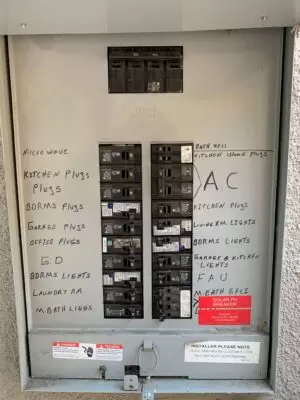

In [15]:
# Visualize compatible matches
if 'classification' in locals():
    print("\n✅ COMPATIBLE PANEL MATCHES:")
    print("="*60)
    for i, panel in enumerate(classification['compatible_matches'][:3], 1):
        if panel['filename']:
            print(f"\n{i}. {panel['filename']}")
            display(Image.open(f"Images/Good/{panel['filename']}"))


❌ INCOMPATIBLE PANEL MATCHES:

1. bad-2-300x400.webp


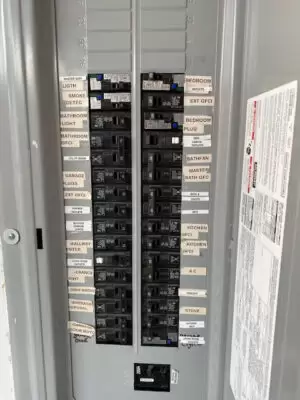


2. breaker-bad.webp


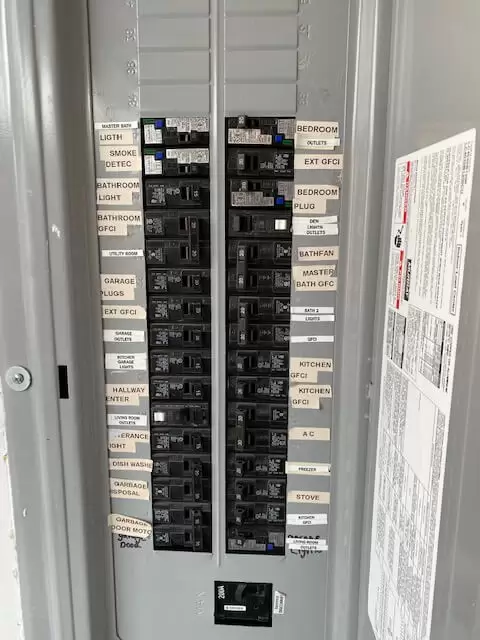

In [16]:
# Visualize incompatible matches
if 'classification' in locals():
    print("\n❌ INCOMPATIBLE PANEL MATCHES:")
    print("="*60)
    for i, panel in enumerate(classification['incompatible_matches'][:3], 1):
        if panel['filename']:
            print(f"\n{i}. {panel['filename']}")
            display(Image.open(f"Images/Bad/{panel['filename']}"))

## Interactive Exploration

Use this cell to run custom queries and explore the dataset

Compatible panels for 'electrical panel with capacity':
  - good-perfect-main-panel-300x400.webp


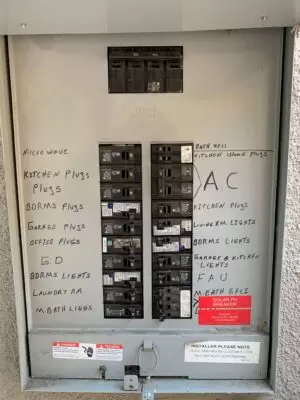

In [17]:
# Custom query examples - search in specific collections

# Search compatible panels
query = "electrical panel with capacity"
results = search_panels_by_text(query, "CompatiblePanels", limit=3)
print(f"Compatible panels for '{query}':")
for r in results:
    print(f"  - {r['filename']}")
    display(Image.open(f"Images/Good/{r['filename']}"))

Finding similar INCOMPATIBLE panels to: breaker-bad.webp


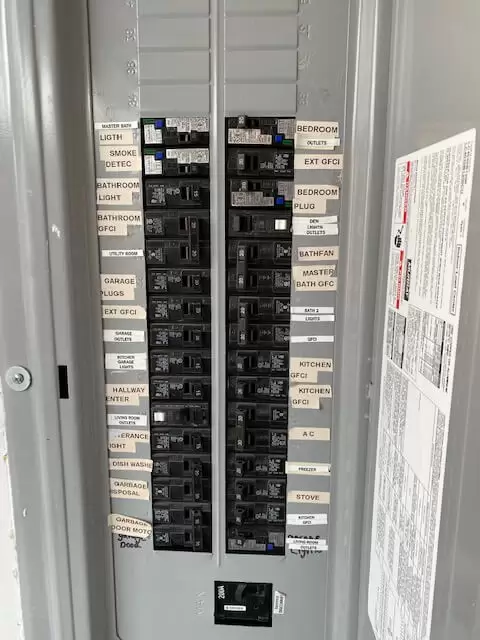


Similar incompatible panels:

bad-2-300x400.webp


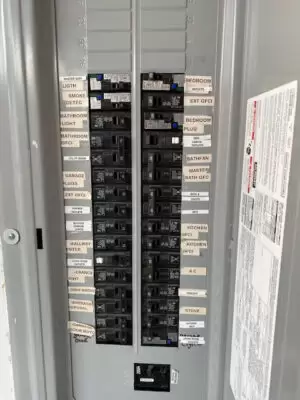

In [18]:
# Image similarity search in incompatible collection
bad_images = [f for f in os.listdir("Images/Bad/") if os.path.splitext(f)[1].lower() in image_extensions] if os.path.exists("Images/Bad/") else []

if bad_images:
    custom_reference = f"Images/Bad/{bad_images[0]}"
    
    print(f"Finding similar INCOMPATIBLE panels to: {os.path.basename(custom_reference)}")
    display(Image.open(custom_reference))
    
    similar = find_similar_panels(custom_reference, "IncompatiblePanels", limit=4)
    print("\nSimilar incompatible panels:")
    for s in similar[1:]:
        print(f"\n{s['filename']}")
        display(Image.open(f"Images/Bad/{s['filename']}"))
else:
    print("No images in Images/Bad/ folder")

## Collection Statistics

View information about the current dataset

In [19]:
# Collection statistics
compatible_collection = client.collections.get("CompatiblePanels")
incompatible_collection = client.collections.get("IncompatiblePanels")

compatible_agg = compatible_collection.aggregate.over_all()
incompatible_agg = incompatible_collection.aggregate.over_all()

print("EV CHARGING PANEL COLLECTION STATISTICS")
print("="*60)
print(f"Compatible panels (Good): {compatible_agg.total_count}")
print(f"Incompatible panels (Bad): {incompatible_agg.total_count}")
print(f"Total panels: {compatible_agg.total_count + incompatible_agg.total_count}")
print(f"\nVector database: Weaviate (meter-image-weaviate)")
print(f"Embedding model: CLIP (multi2vec-clip)")
print("="*60)

EV CHARGING PANEL COLLECTION STATISTICS
Compatible panels (Good): 1
Incompatible panels (Bad): 2
Total panels: 3

Vector database: Weaviate (meter-image-weaviate)
Embedding model: CLIP (multi2vec-clip)


## Next Steps

**POC Findings to Document:**
1. How well does CLIP distinguish between compatible and incompatible panels?
2. Can we identify visual patterns that indicate EV charging compatibility?
3. What's the accuracy of similarity-based classification?
4. Do we need distance thresholds or should we use supervised learning?

**Enhancements to Consider:**
- Extract distance/similarity scores for quantitative classification
- Add more labeled examples to each collection
- Integrate OCR to extract panel capacity ratings
- Build supervised classifier using CLIP embeddings as features
- Add confidence scores based on distance metrics
- Review TBD panels with EV specialist and add to appropriate collection

In [ ]:
# Cleanup - close client connection
# client.close()
# print("Connection closed")

## Interactive Compatibility Analyzer

Gradio interface for uploading panel images and analyzing compatibility with existing panels in the database

In [20]:
%pip install gradio

/home/elmunoz42/anaconda3/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=98479) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [21]:
import gradio as gr
from PIL import Image
import tempfile
import os

def analyze_panel_compatibility(uploaded_image):
    """
    Analyze an uploaded panel image for EV charging compatibility
    Compares against both compatible and incompatible panel collections
    """
    if uploaded_image is None:
        return None, None, None, None, None, None, "Please upload an image"
    
    try:
        # Save uploaded image temporarily
        with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as tmp_file:
            uploaded_image.save(tmp_file.name, format='JPEG')
            temp_path = tmp_file.name
        
        # Encode image for Weaviate
        with open(temp_path, "rb") as file:
            query_image = base64.b64encode(file.read()).decode('utf-8')
        
        # Search in compatible panels
        compatible_collection = client.collections.get("CompatiblePanels")
        compatible_res = compatible_collection.query.near_image(
            near_image=query_image,
            limit=5
        )
        
        # Search in incompatible panels
        incompatible_collection = client.collections.get("IncompatiblePanels")
        incompatible_res = incompatible_collection.query.near_image(
            near_image=query_image,
            limit=5
        )
        
        # Clean up temp file
        os.unlink(temp_path)
        
        if len(compatible_res.objects) == 0 and len(incompatible_res.objects) == 0:
            return None, None, None, None, None, None, "No panels found in database. Please load panels first."
        
        # Get top 3 compatible matches
        compatible_panels = []
        compatible_filenames = []
        for obj in compatible_res.objects[:3]:
            filename = obj.properties.get("filename")
            if filename:
                try:
                    img = Image.open(f"Images/Good/{filename}")
                    compatible_panels.append(img)
                    compatible_filenames.append(filename)
                except Exception as e:
                    print(f"Error loading {filename}: {e}")
        
        # Get top 3 incompatible matches
        incompatible_panels = []
        incompatible_filenames = []
        for obj in incompatible_res.objects[:3]:
            filename = obj.properties.get("filename")
            if filename:
                try:
                    img = Image.open(f"Images/Bad/{filename}")
                    incompatible_panels.append(img)
                    incompatible_filenames.append(filename)
                except Exception as e:
                    print(f"Error loading {filename}: {e}")
        
        # Prepare result summary
        result_text = f"""
✓ EV Charging Compatibility Analysis Complete

Found in database:
  - {len(compatible_res.objects)} compatible panel matches
  - {len(incompatible_res.objects)} incompatible panel matches

✅ TOP COMPATIBLE PANEL MATCHES:
{chr(10).join([f"  • {fn}" for fn in compatible_filenames]) if compatible_filenames else "  None found"}

❌ TOP INCOMPATIBLE PANEL MATCHES:
{chr(10).join([f"  • {fn}" for fn in incompatible_filenames]) if incompatible_filenames else "  None found"}

RECOMMENDATION:
Compare the uploaded panel with the matches above. If it looks more similar 
to the compatible panels, it likely supports EV charging installation.
If it matches the incompatible panels more closely, it may require upgrades.

For final determination, consult with an EV charging specialist.
        """
        
        # Pad results to ensure we have 3 images each
        while len(compatible_panels) < 3:
            compatible_panels.append(None)
        while len(incompatible_panels) < 3:
            incompatible_panels.append(None)
        
        return (
            compatible_panels[0], compatible_panels[1], compatible_panels[2],
            incompatible_panels[0], incompatible_panels[1], incompatible_panels[2],
            result_text
        )
        
    except Exception as e:
        error_msg = f"Error analyzing image: {str(e)}\n\nMake sure Weaviate is running and panels are loaded."
        return None, None, None, None, None, None, error_msg

In [22]:
# Create and launch Gradio interface
with gr.Blocks(title="EV Charging Panel Compatibility Analyzer") as demo:
    gr.Markdown("# ⚡ EV Charging Panel Compatibility Analyzer")
    gr.Markdown("""
    Upload an electrical panel image to analyze its compatibility with EV charging installation.
    The system compares your panel against known compatible and incompatible configurations.
    """)
    
    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(
                label="Upload Panel Image", 
                type="pil",
                height=400
            )
            analyze_btn = gr.Button("⚡ Analyze EV Compatibility", variant="primary", size="lg")
    
    gr.Markdown("## Analysis Results")
    
    result_summary = gr.Textbox(
        label="Compatibility Assessment",
        lines=14,
        max_lines=20
    )
    
    gr.Markdown("### ✅ Similar to EV-Compatible Panels")
    with gr.Row():
        compatible_1 = gr.Image(label="Match #1", type="pil")
        compatible_2 = gr.Image(label="Match #2", type="pil")
        compatible_3 = gr.Image(label="Match #3", type="pil")
    
    gr.Markdown("### ❌ Similar to EV-Incompatible Panels")
    with gr.Row():
        incompatible_1 = gr.Image(label="Match #1", type="pil")
        incompatible_2 = gr.Image(label="Match #2", type="pil")
        incompatible_3 = gr.Image(label="Match #3", type="pil")
    
    # Connect the analyze button
    analyze_btn.click(
        fn=analyze_panel_compatibility,
        inputs=image_input,
        outputs=[
            compatible_1, compatible_2, compatible_3,
            incompatible_1, incompatible_2, incompatible_3,
            result_summary
        ]
    )
    
    gr.Markdown("""
    ---
    **How it works:**
    - Images are embedded using CLIP (multi2vec-clip) model
    - System searches two collections: Compatible and Incompatible panels
    - Visual similarity indicates likely EV charging compatibility
    - Compatible panels typically have sufficient capacity and proper configuration
    - Incompatible panels may lack capacity or require electrical upgrades
    
    **Disclaimer:** This is a proof-of-concept tool. Always consult with a licensed 
    electrician and EV charging specialist before making installation decisions.
    """)

# Launch the interface
demo.launch(share=False, server_port=7860)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


/home/elmunoz42/anaconda3/lib/python3.13/site-packages/gradio/routes.py:1350: DeprecationWarning: 'HTTP_422_UNPROCESSABLE_ENTITY' is deprecated. Use 'HTTP_422_UNPROCESSABLE_CONTENT' instead.
  return await queue_join_helper(body, request, username)
